In [1]:
# load required libraries
options(stringsAsFactors = F)
options (repr.plot.width = 12, repr.plot.height = 7)
suppressPackageStartupMessages({
library(DESeq2)
library(sva)
library(ggplot2)
library(pheatmap)
library(ggforce)
library(clusterProfiler)
library(org.Hs.eg.db)
library(enrichplot)
library(tidyr)
library(dplyr)
})
set.seed(123)

In [2]:
# load count matrix
count_matrix <- read.table("./matrix/featureCounts.txt", header = T, sep = "\t", row.names = 1, check.names = F, stringsAsFactors = F)
count_matrix <- count_matrix[, c((ncol(count_matrix) - 7):ncol(count_matrix))]
tail(count_matrix)
colnames(count_matrix) <- unlist(strsplit(colnames(count_matrix), ".", fixed = T))[seq(1, 2 * ncol(count_matrix), 2)]
countTable <- count_matrix
countTable <- countTable[- which(rowSums(countTable) < 1), ]
countTable <- countTable[, sort(colnames(countTable))]
head(countTable)

,C1.bam,C2.bam,C3.bam,C4.bam,Z41.bam,Z42.bam,Z43.bam,Z44.bam
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
RNA5-8SN4,8,7,2,15,0,0,2,1
AL353644.2,0,0,0,0,0,0,0,0
AC007325.3,0,0,0,0,0,0,0,0
AC007325.1,0,0,0,0,0,0,0,0
AC007325.4,1,2,0,3,2,0,0,1
AC007325.2,2,7,7,0,4,1,6,4


,C1,C2,C3,C4,Z41,Z42,Z43,Z44
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
WASH7P,139,128,101,130,135,105,115,139
MIR6859-1,2,8,1,3,3,3,5,4
MIR1302-2HG,0,0,1,0,0,0,0,0
AL627309.1,1,0,0,1,0,0,1,0
AL627309.6,0,4,0,0,0,1,0,0
AL627309.5,1,1,0,0,1,0,2,0


In [3]:
# create col data
colData <- data.frame(row.names = colnames(countTable), condition = unlist(strsplit(colnames(countTable), "\\d+")))
colData

,condition
,<chr>
C1,C
C2,C
C3,C
C4,C
Z41,Z
Z42,Z
Z43,Z
Z44,Z


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


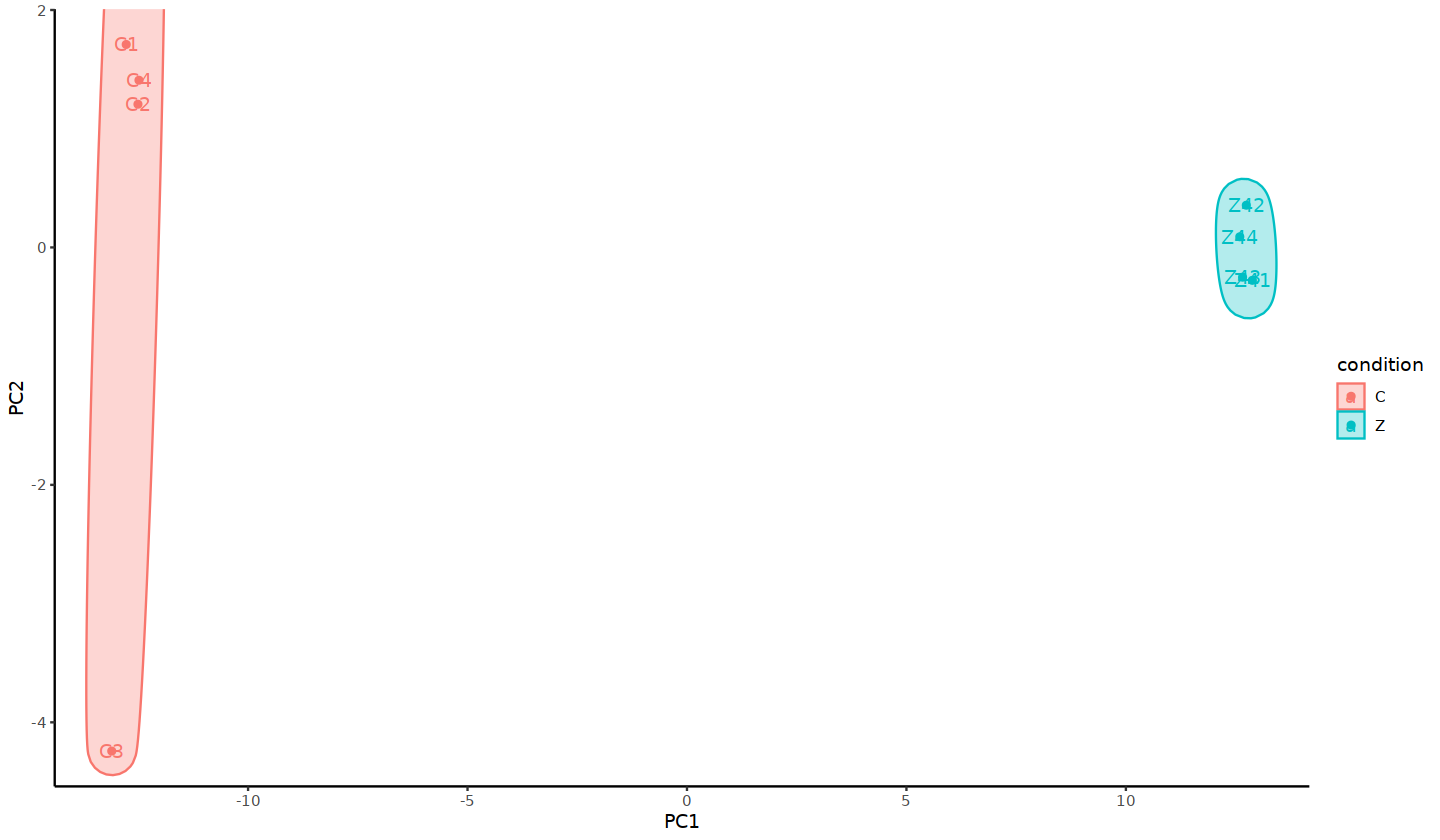

In [4]:
# sample pca
dds <- DESeqDataSetFromMatrix(countData = countTable, colData = colData, design = ~ condition)
vsd <- vst(dds)
pcaData <- plotPCA(vsd, intgroup = c("condition"), returnData = TRUE)
pcaData$condition <- factor(pcaData$condition, levels = c("C", "Z"))
ggplot(pcaData, aes(x = PC1, y = PC2, color = condition)) + geom_point() + geom_mark_ellipse(aes(fill = condition, color = condition)) + geom_text(aes(label = name)) + theme_classic()

In [5]:
# differential expression
dds <- DESeq(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [6]:
# compare Z vs C
res <- results(dds, contrast = c("condition", "Z", "C"))
res_ordered <- res[order(res$padj), ]
write.csv(res_ordered, "./DESeq2_results/DESeq2_results_Z_vs_C_all.csv")
write.csv(subset(res_ordered, log2FoldChange >= 1 & padj <= 0.05), "./DESeq2_results/DESeq2_results_Z_vs_C_up.csv")
write.csv(subset(res_ordered, log2FoldChange <= -1 & padj <= 0.05), "./DESeq2_results/DESeq2_results_Z_vs_C_down.csv")

In [7]:
# volcano plot data
data_degs <- read.csv("./DESeq2_results/DESeq2_results_Z_vs_C_all.csv", row.names = 1)
data_degs$log10_padj <- -log10(data_degs$padj + 10^-300)
data_degs$gene_name <- rownames(data_degs)

data_degs$regulation <- "Not significant"
data_degs[which(abs(data_degs$log2FoldChange) < 0.15),'regulation'] <- 'Not significant' 
data_degs[which((data_degs$log2FoldChange>=0.15)&(data_degs$padj <= 0.05)), 'regulation'] <- 'Up'
data_degs[which((data_degs$log2FoldChange<=-0.15)&(data_degs$padj <= 0.05)),'regulation'] <- 'Down'
head(data_degs)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log10_padj,gene_name,regulation
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
PAQR8,1961.4870,-2.839273,0.05917145,-47.98384,0.000000e+00,0.000000e+00,300.0000,PAQR8,Down
AKR1B1,26787.9778,-3.010464,0.04374956,-68.81129,0.000000e+00,0.000000e+00,300.0000,AKR1B1,Down
PLAT,8405.6584,-2.603339,0.06036862,-43.12404,0.000000e+00,0.000000e+00,300.0000,PLAT,Down
TNFSF15,1651.6158,-2.687950,0.07415961,-36.24547,1.171345e-287,6.158054e-284,283.2106,TNFSF15,Down
IL1B,573.3269,-4.195069,0.11606937,-36.14278,4.831640e-286,2.032091e-282,281.6921,IL1B,Down
NADK2,7151.7801,-2.313021,0.07477043,-30.93497,4.047053e-210,1.418425e-206,205.8482,NADK2,Down


Warning message:
“Removed 11273 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 11273 rows containing missing values (`geom_point()`).”


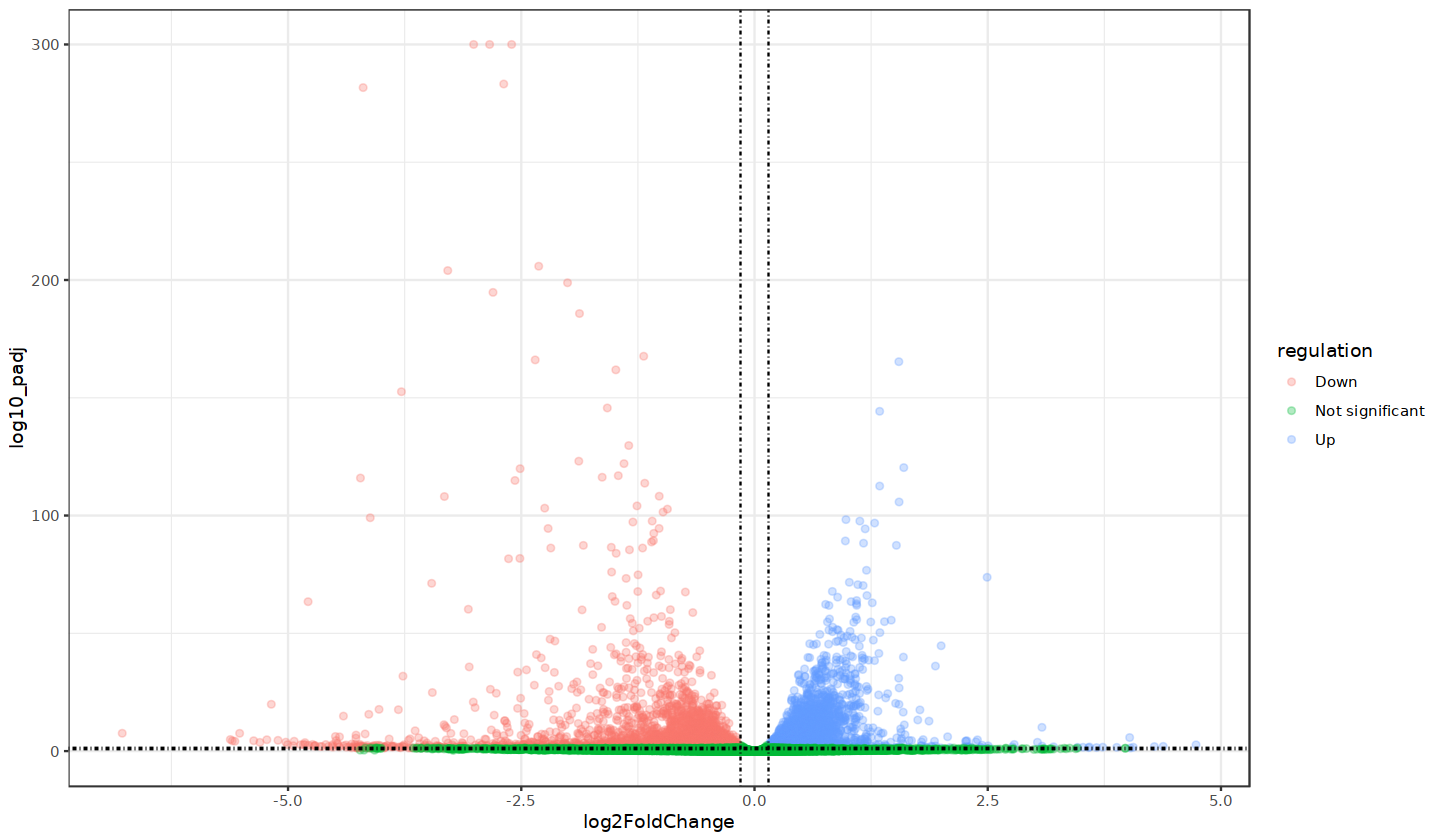

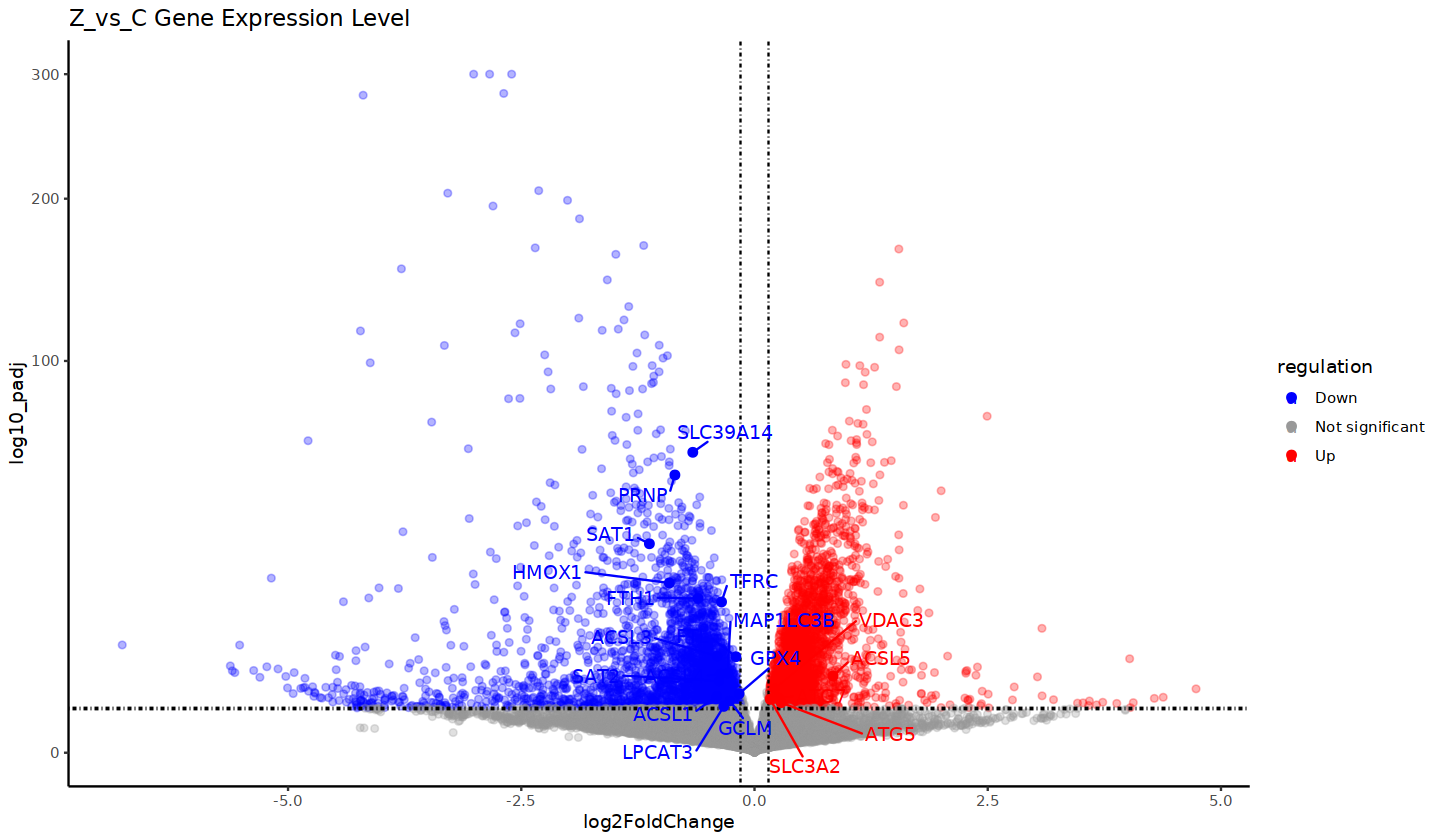

In [8]:
# volcano plot
p <- ggplot(data = data_degs, 
            aes(x = log2FoldChange, 
                y = log10_padj, color = regulation)) +
  geom_point(alpha=0.3, size=1.5) + 
  geom_vline(xintercept=c(-0.15,0.15),lty=4,col="black",lwd=0.5) +
  geom_hline(yintercept = -log10(0.05),lty=4,col="black",lwd=0.8) +
  theme_bw()
p

for_label <- head(data_degs[order(data_degs$padj), ], 10)
ferroptosis_genes <- c('IL1B','NDRG1','HIF1A','SLC39A14','IL6','GABARAPL1','EPAS1','SAT1','BACH1','HMOX1','PIK3CA','CTSB','TFRC','IREB2','LINC00472','DDR2','FOXO4','WIPI1','TIMP1','YAP1','ACSF2','SLC38A1','PRKAA2','EGR1','ATM','CYGB','TGFBR1','NR1D1','ACSL4','WWTR1','ATF4','ACADSB','ZEB1','ANO6','LYRM1','KDM5A','TNFAIP3','PHF21A','PANX1','MIB2','TRIM46','SIRT3','ACSL1','ADAM23','ALOX12','ATG13','CCDC6','MMD','LPCAT3','DUOX2','CD82','RRM2','KIF20A','EZH2','NF2','HSPA5','CAV1','PARP1','NT5DC2','CDC25A','FANCD2','AHCY','PARP2','IDH2','DAZAP1','KLHDC3','VCP','TYRO3','MAPKAP1','FH','SUV39H1','COPZ1','GALNT14','GSTM1','RBMS1','ARF6','FADS2','PTPN18','GLRX5','OIP5-AS1','NEDD4','BCAT2','SRSF9','PARK7','DHODH','JUN','CREB5','PML','SIAH2','HELLS','PARP12','CAMKK2','SLC3A2','PRDX1','STK11','MTOR','CHMP6','TFAM','TFRC','PTGS2')
ferroptosis_genes <- c('SLC39A14','PRNP','SAT1','HMOX1','FTH1','TFRC','ACSL3','FTL','MAP1LC3B','ACSL4','ACSL5','SAT2','VDAC3','GPX4','ACSL1','ATG7','SLC3A2','GCLM','ATG5','LPCAT3')
for_label <- data_degs[ferroptosis_genes, ]
for_label <- subset(for_label, padj <= 0.05)

p + ggtitle("Z_vs_C Gene Expression Level") +
  geom_point(size = 2, data = for_label, aes(color = regulation)) +
  ggrepel::geom_text_repel(aes(label = gene_name, color = regulation),
                           data = for_label, min.segment.length = 0, seed = 42, box.padding = 0.5, max.overlaps = Inf) + scale_color_manual(values=c("blue","grey60","red")) + theme_classic() +
                           scale_y_sqrt()

In [9]:
# functional enrichment
library(org.Dm.eg.db)
degs_all <- read.csv("./DESeq2_results/DESeq2_results_Z_vs_C_all.csv", row.names = 1, check.names = F, stringsAsFactors = F)
degs_significant <- subset(degs_all, abs(log2FoldChange) >= 1 & padj <= 0.05)

degs_down <- rownames(subset(degs_significant, log2FoldChange < 0))
degs_down_transfered <- bitr(degs_down, fromType = 'SYMBOL', toType = 'ENTREZID', OrgDb = "org.Hs.eg.db")
degs_down_id <- degs_down_transfered$ENTREZID

ego_down <- enrichGO(gene = degs_down,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.1,
                qvalueCutoff  = 0.1)
write.csv(ego_down, "enrichment/GO_down.csv")

kk_down <- enrichKEGG(gene = degs_down_id,
                 organism  = 'hsa',
                 pvalueCutoff = 0.1)
kk_down_readable <- setReadable(kk_down, OrgDb = org.Hs.eg.db, keyType = "ENTREZID")
write.csv(kk_down_readable, "enrichment/KEGG_down.csv")

degs_up <- rownames(subset(degs_significant, log2FoldChange > 0))
degs_up_transfered <- bitr(degs_up, fromType = 'SYMBOL', toType = 'ENTREZID', OrgDb = "org.Hs.eg.db")
degs_up_id <- degs_up_transfered$ENTREZID

ego_up <- enrichGO(gene = degs_up,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.1,
                qvalueCutoff  = 0.1)
write.csv(ego_up, "enrichment/GO_up.csv")

kk_up <- enrichKEGG(gene = degs_up_id,
                 organism  = 'hsa',
                 pvalueCutoff = 0.1)
kk_up_readable <- setReadable(kk_up, OrgDb = org.Hs.eg.db, keyType = "ENTREZID")
write.csv(kk_up_readable, "enrichment/KEGG_up.csv")



'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(degs_down, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“21.25% of input gene IDs are fail to map...”
Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(degs_up, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Hs.eg.db"):
“14.96% of input gene IDs are fail to map...”


In [10]:
# functional enrichment combine up and down
degs_all <- read.csv("./DESeq2_results/DESeq2_results_Z_vs_C_all.csv", row.names = 1, check.names = F, stringsAsFactors = F)
degs_significant <- subset(degs_all, abs(log2FoldChange) >= 0.15 & padj <= 0.05)

degs_up_down <- rownames(degs_significant)
degs_up_down_transfered <- bitr(degs_up_down, fromType = 'SYMBOL', toType = 'ENTREZID', OrgDb = "org.Hs.eg.db")
degs_up_down_id <- degs_up_down_transfered$ENTREZID

ego_up_down <- enrichGO(gene = degs_up_down,
                OrgDb         = org.Hs.eg.db,
                keyType       = 'SYMBOL',
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.5,
                qvalueCutoff  = 0.5)
write.csv(ego_up_down, "enrichment/GO_up_down.csv")

kk_up_down <- enrichKEGG(gene = degs_up_down_id,
                 organism  = 'hsa',
                 pvalueCutoff = 0.5,
                 qvalueCutoff = 0.5)
kk_up_down_readable <- setReadable(kk_up_down, OrgDb = org.Hs.eg.db, keyType = "ENTREZID")
write.csv(kk_up_down_readable, "enrichment/KEGG_up_down.csv")

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(degs_up_down, fromType = "SYMBOL", toType = "ENTREZID", :
“6.43% of input gene IDs are fail to map...”


,Cell cycle,Nucleocytoplasmic transport,DNA replication,Lysosome,Small cell lung cancer,Base excision repair,Epithelial cell signaling in Helicobacter pylori infection,Ubiquitin mediated proteolysis,Cellular senescence,Ribosome,⋯,Asthma,Systemic lupus erythematosus,Maturity onset diabetes of the young,Cytokine-cytokine receptor interaction,Hormone signaling,Autoimmune thyroid disease,Taste transduction,Staphylococcus aureus infection,Neuroactive ligand-receptor interaction,Olfactory transduction
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CDC20,1,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CCNA2,1,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0
PCNA,1,0,1,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
PLK1,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
AURKB,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
MCM6,1,0,1,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


,Cell cycle,Nucleocytoplasmic transport,DNA replication,Lysosome,Small cell lung cancer,Base excision repair,Epithelial cell signaling in Helicobacter pylori infection,Ubiquitin mediated proteolysis,Cellular senescence,Ribosome,⋯,Asthma,Systemic lupus erythematosus,Maturity onset diabetes of the young,Cytokine-cytokine receptor interaction,Hormone signaling,Autoimmune thyroid disease,Taste transduction,Staphylococcus aureus infection,Neuroactive ligand-receptor interaction,Olfactory transduction
CDC20,1.1862924,0,0.0000000,0,0,0.0000000,0,1.186292,0.000000,0,⋯,0,0,0,0,0,0,0,0,0,0
CCNA2,1.2003136,0,0.0000000,0,0,0.0000000,0,0.000000,1.200314,0,⋯,0,0,0,0,0,0,0,0,0,0
PCNA,0.8343083,0,0.8343083,0,0,0.8343083,0,0.000000,0.000000,0,⋯,0,0,0,0,0,0,0,0,0,0
PLK1,1.0947095,0,0.0000000,0,0,0.0000000,0,0.000000,0.000000,0,⋯,0,0,0,0,0,0,0,0,0,0
AURKB,1.2622603,0,0.0000000,0,0,0.0000000,0,0.000000,0.000000,0,⋯,0,0,0,0,0,0,0,0,0,0
MCM6,1.0847049,0,1.0847049,0,0,0.0000000,0,0.000000,0.000000,0,⋯,0,0,0,0,0,0,0,0,0,0


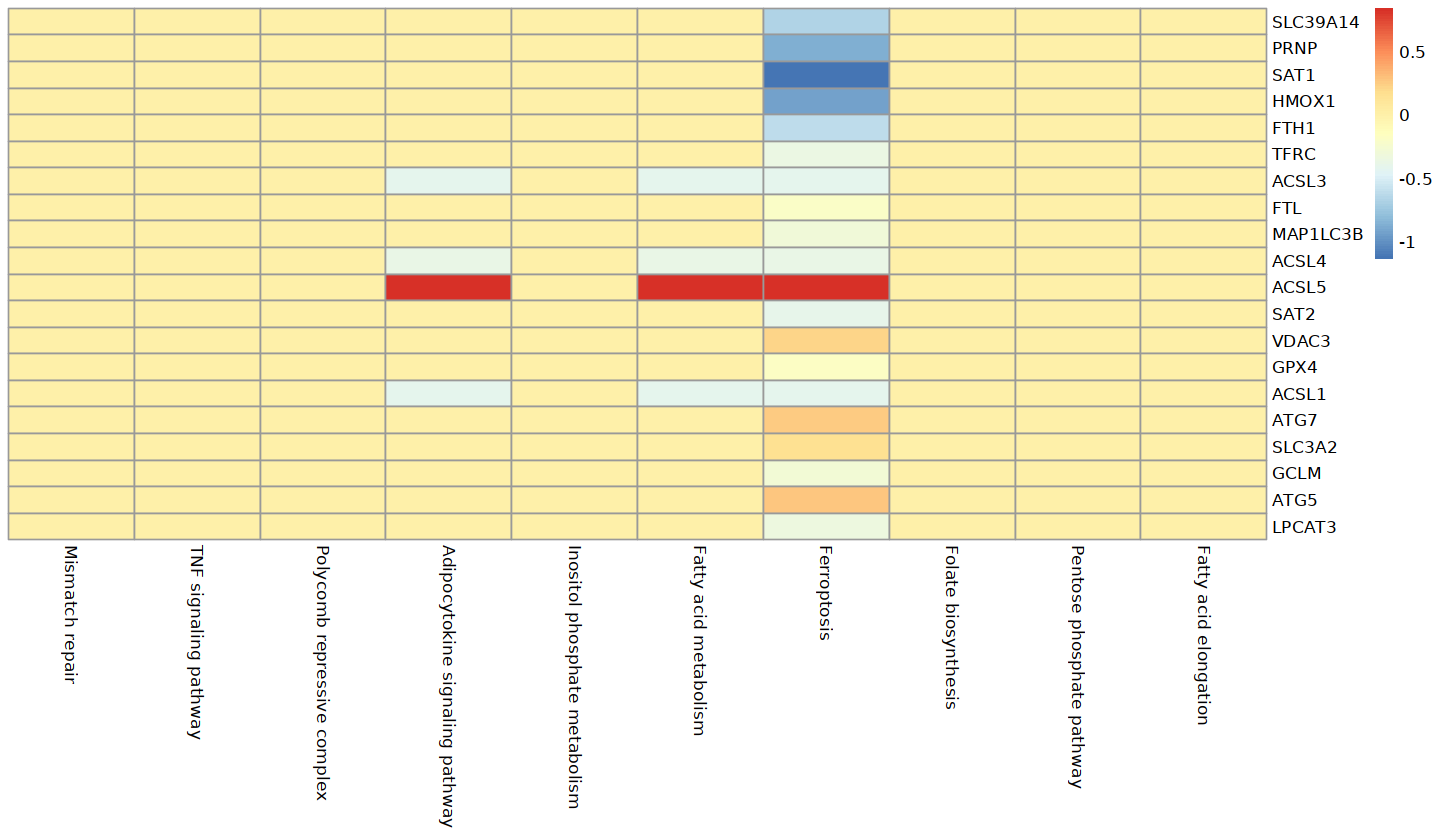

In [11]:
# Split `geneID` column into individual genes for each category
# Separate the geneID column into individual genes
df <- kk_up_down_readable@result
gene_category_df <- df %>%
  mutate(genes = strsplit(as.character(geneID), "/")) %>%  # Split geneID by "/"
  unnest(genes)                                            # Expand into long format

# Create gene-category matrix
gene_category_matrix <- gene_category_df %>%
  select(genes, Description) %>%           # Select genes and categories
  mutate(value = 1) %>%                    # Assign a value of 1 to indicate membership
  pivot_wider(names_from = Description,    # Pivot categories into columns
              values_from = value,         # Use "value" column
              values_fill = 0)             # Fill missing values with 0

# View the resulting matrix
gene_category_matrix <- as.data.frame(gene_category_matrix)
rownames(gene_category_matrix) <- gene_category_matrix$genes
gene_category_matrix <- gene_category_matrix[ , -1]  # Remove the gene column
head(gene_category_matrix)

# Convert gene_category_matrix to a numeric matrix (if not already)
gene_category_matrix <- as.matrix(gene_category_matrix)

# Create a named vector of log2FoldChange values from fold_change_df
log2fc_vector <- setNames(degs_all$log2FoldChange, rownames(degs_all))

# Replace "1" in the matrix with the corresponding log2FoldChange values
for (gene in rownames(gene_category_matrix)) {
  if (gene %in% names(log2fc_vector)) {
    gene_category_matrix[gene, gene_category_matrix[gene, ] == 1] <- log2fc_vector[gene]
  }
}

# View the updated gene-category matrix
head(gene_category_matrix)

selected_kegg_terms <- c('Mismatch repair','TNF signaling pathway','Polycomb repressive complex','Adipocytokine signaling pathway','Inositol phosphate metabolism','Fatty acid metabolism','Ferroptosis','Folate biosynthesis','Pentose phosphate pathway','Fatty acid elongation')
selected_genes <- c('IL1B','NDRG1','HIF1A','SLC39A14','IL6','GABARAPL1','EPAS1','SAT1','BACH1','HMOX1','PIK3CA','CTSB','TFRC','IREB2','LINC00472','DDR2','FOXO4','WIPI1','TIMP1','YAP1','ACSF2','SLC38A1','PRKAA2','EGR1','ATM','CYGB','TGFBR1','NR1D1','ACSL4','WWTR1','ATF4','ACADSB','ZEB1','ANO6','LYRM1','KDM5A','TNFAIP3','PHF21A','PANX1','MIB2','TRIM46','SIRT3','ACSL1','ADAM23','ALOX12','ATG13','CCDC6','MMD','LPCAT3','DUOX2','CD82','RRM2','KIF20A','EZH2','NF2','HSPA5','CAV1','PARP1','NT5DC2','CDC25A','FANCD2','AHCY','PARP2','IDH2','DAZAP1','KLHDC3','VCP','TYRO3','MAPKAP1','FH','SUV39H1','COPZ1','GALNT14','GSTM1','RBMS1','ARF6','FADS2','PTPN18','GLRX5','OIP5-AS1','NEDD4','BCAT2','SRSF9','PARK7','DHODH','JUN','CREB5','PML','SIAH2','HELLS','PARP12','CAMKK2','SLC3A2','PRDX1','STK11','MTOR','CHMP6','TFAM','TFRC','PTGS2')
selected_genes <- c('SLC39A14','PRNP','SAT1','HMOX1','FTH1','TFRC','ACSL3','FTL','MAP1LC3B','ACSL4','ACSL5','SAT2','VDAC3','GPX4','ACSL1','ATG7','SLC3A2','GCLM','ATG5','LPCAT3')
gene_category_matrix <- as.data.frame(gene_category_matrix)
go_heatmap_data <- gene_category_matrix[intersect(selected_genes, rownames(gene_category_matrix)), selected_kegg_terms]
pheatmap(go_heatmap_data, cluster_cols = F, cluster_rows = F)

Loading required package: viridisLite

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


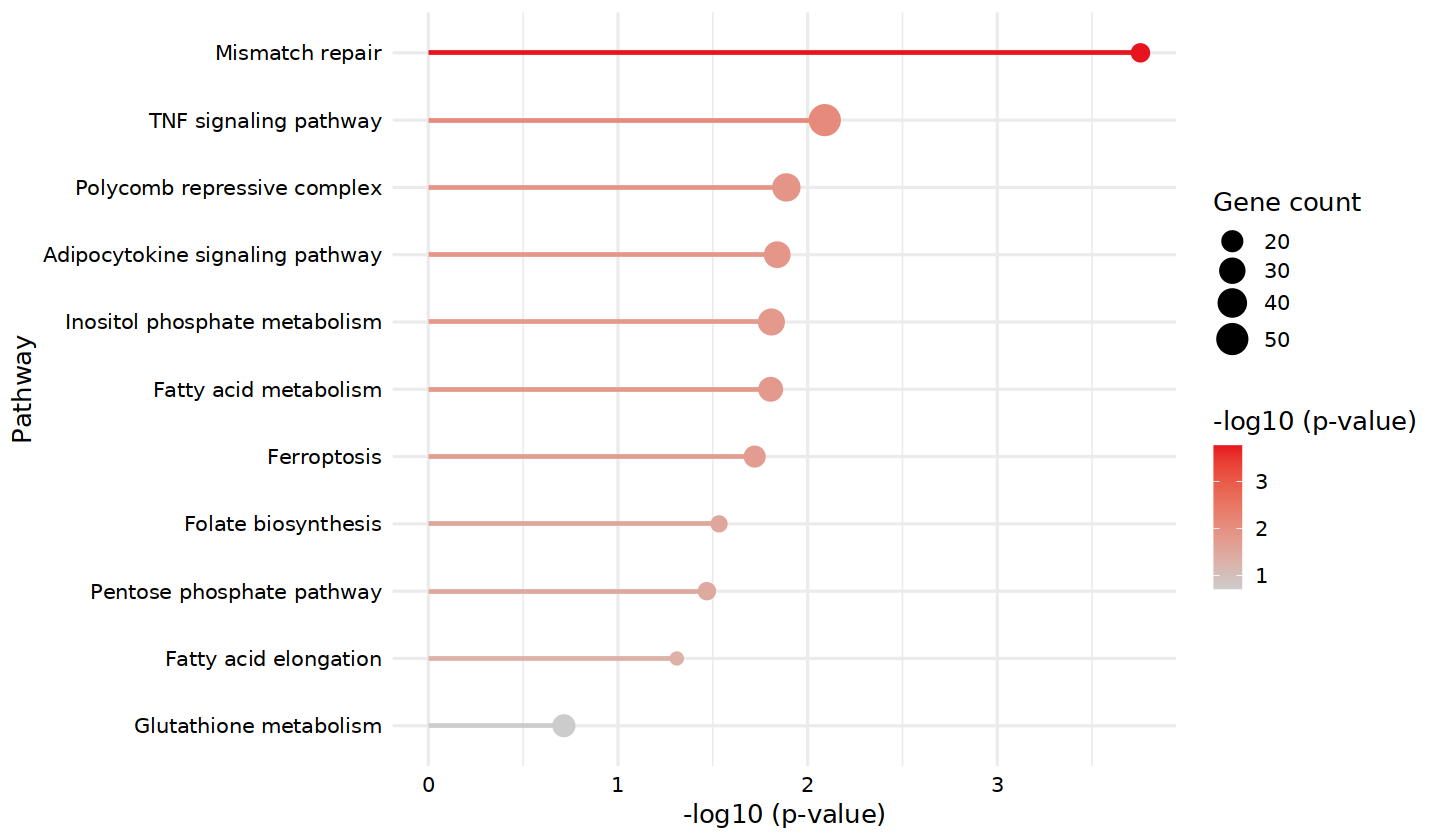

In [12]:
# lolipop
# Add -log10(pvalue) for plotting
library(viridis)
df <- kk_up_down_readable@result
selected_kegg_terms <- c('Mismatch repair','TNF signaling pathway','Polycomb repressive complex','Adipocytokine signaling pathway','Inositol phosphate metabolism','Fatty acid metabolism','Ferroptosis','Folate biosynthesis','Pentose phosphate pathway','Fatty acid elongation','Glutathione metabolism')
df <- df[df$Description %in% selected_kegg_terms, ]
df <- df %>%
  mutate(log10_pvalue = -log10(pvalue))

# Create the lollipop plot
ggplot(df, aes(x = reorder(Description, log10_pvalue), y = log10_pvalue)) + 
  geom_segment(aes(x = Description, xend = Description, y = 0, yend = log10_pvalue, color = log10_pvalue), size = 1) +
  geom_point(aes(size = Count, color = log10_pvalue)) +
  scale_color_gradient(low = "grey80", high = "#E71420") +  # Color based on -log10(pvalue)
  scale_size_continuous(range = c(3, 8)) +          # Adjust circle size range
  coord_flip() +                                     # Flip coordinates for horizontal bars
  labs(
    x = "Pathway",
    y = "-log10 (p-value)",
    # title = "Lollipop Plot of Pathway Enrichment",
    color = "-log10 (p-value)",
    size = "Gene count"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    axis.text.y = element_text(size = 12, color = "black"),
    axis.text.x = element_text(size = 12, color = "black")
  )
ggsave("./figure/KEGG_lolipop.pdf", width = 7, height = 4.25)

In [13]:
# plot heatmap
# Extract normalized counts
normalized_counts <- counts(dds, normalized = TRUE)

# Define a vector of selected genes (e.g., based on differential expression results)
selected_genes <- c('IL1B','NDRG1','HIF1A','SLC39A14','IL6','GABARAPL1','EPAS1','SAT1','BACH1','HMOX1','PIK3CA','CTSB','TFRC','IREB2','LINC00472','DDR2','FOXO4','WIPI1','TIMP1','YAP1','ACSF2','SLC38A1','PRKAA2','EGR1','ATM','CYGB','TGFBR1','NR1D1','ACSL4','WWTR1','ATF4','ACADSB','ZEB1','ANO6','LYRM1','KDM5A','TNFAIP3','PHF21A','PANX1','MIB2','TRIM46','SIRT3','ACSL1','ADAM23','ALOX12','ATG13','CCDC6','MMD','LPCAT3','DUOX2','CD82','RRM2','KIF20A','EZH2','NF2','HSPA5','CAV1','PARP1','NT5DC2','CDC25A','FANCD2','AHCY','PARP2','IDH2','DAZAP1','KLHDC3','VCP','TYRO3','MAPKAP1','FH','SUV39H1','COPZ1','GALNT14','GSTM1','RBMS1','ARF6','FADS2','PTPN18','GLRX5','OIP5-AS1','NEDD4','BCAT2','SRSF9','PARK7','DHODH','JUN','CREB5','PML','SIAH2','HELLS','PARP12','CAMKK2','SLC3A2','PRDX1','STK11','MTOR','CHMP6','TFAM','TFRC','PTGS2')
selected_genes <- c('SLC39A14','PRNP','SAT1','HMOX1','FTH1','TFRC','ACSL3','FTL','MAP1LC3B','ACSL4','ACSL5','SAT2','VDAC3','GPX4','ACSL1','ATG7','SLC3A2','GCLM','ATG5','LPCAT3')
selected_genes <- c('SLC3A2','SLC39A14','GCLM','ACSL4','TFRC','HMOX1','ACSL1','LPCAT3','DHODH','IREB2','SAT1','HIF1A','EPAS1','BACH1','ATF4','TNFAIP3','DUOX2','PARP1','GSTM1','FADS2','PRDX1','PTGS2','MTOR','NEDD4')
# selected_genes <- intersect(selected_genes, rownames(normalized_counts_subset))

# Subset the normalized counts matrix for the selected genes
normalized_counts_subset <- normalized_counts[selected_genes, ]

# Plot the heatmap
library(pheatmap)
pheatmap(
  log2(normalized_counts_subset + 1),          # Use log-transformed counts
  cluster_rows = TRUE,            # Cluster genes (rows)
  cluster_cols = F,            # Cluster samples (columns)
  scale = "row",                  # Scale rows to have mean = 0, variance = 1
  color = colorRampPalette(c("#1F4DA0", "white", "#E71420"))(50),  # Custom color scale
  fontsize_row = 10,              # Font size for row labels (genes)
  fontsize_col = 10,               # Font size for column labels (samples)
  filename = "figure/pheatmap_ferroptosis_genes.pdf",
  width = 3.2,
  height = 3.8
)

In [14]:
# list the session info
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] viridis_0.6.2               viridisLite_0.4.1          
 [3] org.Dm.eg.db_3.16.0         dplyr_1.1.1                
 [5] tidyr_1.3.0                 enrichplot_1.18.4          
 [7] org.Hs.eg.db_3.16.0         AnnotationDbi_1.60.2       
 [9] clusterProfiler_4.6.2       ggforce_0.4.1              
[11] pheatmap_1.0.12             ggplot2_3.4.4              
[13] sva_3.46.0                  Bioc